# Group Assignment #4: Spatial Analysis

**UP 206A | Winter 2021 | By: Angelica Ruiz**

For this assignment, I'll be focusing on conduting a spatial autocorrelation for the CalEnviroScreen 3.0 indicators, specifically focusing on asthma, diesel PM, and PM 2.5. Through this analysis, I hope to further explore the impact of warehouses on the communities in the Inland Empire. Not only with thiss analysis provide a better visual picture of the impact, but it will show any potential statistical significance of the data.

# Libraries

In [20]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

# Data

Next, I'm going to import the CalEnviroScreen 3.0 dataset and begin cleaning it up.

## Import Data

In [21]:
#import ces data
ces_gdf = gpd.read_file('ces/CES3June2018Update.shp')
ces_gdf.head()

tract  pop2010     California    ZIP         City   Longitude  \
0  6.083002e+09     3930  Santa Barbara  93454  Santa Maria -120.427059   
1  6.083002e+09    11406  Santa Barbara  93455  Santa Maria -120.478083   
2  6.083002e+09     2084  Santa Barbara  93454  Santa Maria -120.426777   
3  6.083002e+09     4375  Santa Barbara  93455  Santa Maria -120.410028   
4  6.083002e+09     3826  Santa Barbara  93455  Santa Maria -120.427716   

    Latitude  CIscore  CIscoreP  ozone  ...  Native_Ame  Asian_Amer  \
0  34.930669    29.51        59  0.035  ...         0.5         7.2   
1  34.928796    33.17        65  0.035  ...         0.2         5.5   
2  34.942111    22.85        45  0.035  ...         0.5         2.9   
3  34.871428     4.45         2  0.035  ...         0.6         4.0   
4  34.872288     5.28         3  0.035  ...         0.8         3.5   

   Other_pct  OBJECTID_1  CIdecile  CIvigintil    Shape_Leng    Shape_Area  \
0        1.6        3507         6          12   6999.357622  2.847611e+06   
1        1.6        2733         7          14  19100.578003  1.635292e+07   
2        2.6        4689         5           9   4970.985933  1.352330e+06   
3        2.6        7864         1           1   6558.956142  2.417717e+06   
4        3.2        7863         1           1   6570.368642  2.608422e+06   

             CES2018_Rn                                           geometry  
0                55-60%  POLYGON ((-39795.070 -341919.191, -38126.384 -...  
1                65-70%  POLYGON ((-39795.070 -341919.191, -39803.632 -...  
2                40-45%  POLYGON ((-38115.747 -341130.248, -38126.384 -...  
3  1-5% (lowest scores)  POLYGON ((-37341.662 -348530.437, -37252.307 -...  
4  1-5% (lowest scores)  POLYGON ((-39465.107 -348499.262, -38244.305 -...  

[5 rows x 71 columns]

## Clean CES Dataset

### Subset to only include Riverside and San Bernardino Counties

In [22]:
#only keep Riverside and San Bernardino Counties
ces_ie = ces_gdf.loc[ces_gdf['California'].isin(['Riverside', 'San Bernardino'])]
ces_ie.head(-10)

tract  pop2010      California    ZIP         City   Longitude  \
3525  6.071010e+09     4817  San Bernardino  92392  Victorville -117.356568   
3526  6.071010e+09     4653  San Bernardino  92392  Victorville -117.340701   
3527  6.071009e+09    22862  San Bernardino  92392  Victorville -117.428884   
3528  6.071010e+09     6456  San Bernardino  92392  Victorville -117.358124   
3529  6.071010e+09     4941  San Bernardino  92392  Victorville -117.372900   
...            ...      ...             ...    ...          ...         ...   
4353  6.065043e+09     5993       Riverside  92587     Sun City -117.225585   
4354  6.065043e+09     5768       Riverside  92585     Sun City -117.221427   
4355  6.065043e+09     5338       Riverside  92585     Sun City -117.166693   
4356  6.065043e+09     9184       Riverside  92584      Menifee -117.165786   
4357  6.065041e+09     2995       Riverside  92860        Norco -117.601599   

       Latitude  CIscore  CIscoreP  ozone  ...  Native_Ame  Asian_Amer  \
3525  34.478278    32.05        63  0.065  ...         0.4         4.1   
3526  34.490262    33.14        65  0.065  ...         0.3         3.8   
3527  34.486497    21.60        42  0.065  ...         0.4         5.1   
3528  34.494098    24.17        48  0.065  ...         0.6         4.8   
3529  34.476874    28.29        57  0.065  ...         0.3         3.8   
...         ...      ...       ...    ...  ...         ...         ...   
4353  33.692413    15.93        28  0.060  ...         0.2         4.7   
4354  33.737713    27.87        56  0.062  ...         0.3         3.5   
4355  33.759282    35.65        70  0.065  ...         0.3         1.7   
4356  33.703730    21.19        41  0.062  ...         0.4         5.4   
4357  33.910384    16.13        28  0.060  ...         0.9         4.8   

      Other_pct  OBJECTID_1  CIdecile  CIvigintil    Shape_Leng    Shape_Area  \
3525        3.0        3070         7          13   6446.067750  2.234623e+06   
3526        3.0        2679         7          14  10682.341723  4.376862e+06   
3527        3.3        4611         5           9  30656.735175  4.762563e+07   
3528        2.9        4221         5          10   9149.886130  4.521891e+06   
3529        3.0        3448         6          12   6570.765315  2.451707e+06   
...         ...         ...       ...         ...           ...           ...   
4353        3.1        5742         3           6  14914.996372  8.127566e+06   
4354        1.9        3399         6          12  24428.403911  2.060166e+07   
4355        1.5        2637         7          14  19783.389662  1.687245e+07   
4356        2.5        4567         5           9  12964.034877  9.396258e+06   
4357        2.1        5738         3           6   8079.529309  2.812385e+06   

      CES2018_Rn                                           geometry  
3525      60-65%  POLYGON ((242536.589 -390593.956, 242014.688 -...  
3526      65-70%  POLYGON ((244643.842 -386686.546, 244651.334 -...  
3527      40-45%  POLYGON ((242295.882 -386571.955, 240430.952 -...  
3528      45-50%  POLYGON ((243107.997 -386548.632, 243120.247 -...  
3529      55-60%  POLYGON ((240303.166 -390663.295, 240001.277 -...  
...          ...                                                ...  
4353      25-30%  POLYGON ((257490.630 -475495.774, 257689.470 -...  
4354      55-60%  POLYGON ((258650.219 -468395.441, 259846.187 -...  
4355      65-70%  POLYGON ((260181.367 -467124.137, 260203.737 -...  
4356      40-45%  POLYGON ((263954.794 -477133.731, 262335.522 -...  
4357      25-30%  POLYGON ((221958.124 -453954.010, 222422.104 -...  

[812 rows x 71 columns]

### Delete Variables I don't Need

In [23]:
#list column names
list(ces_ie)

['tract',
 'pop2010',
 'California',
 'ZIP',
 'City',
 'Longitude',
 'Latitude',
 'CIscore',
 'CIscoreP',
 'ozone',
 'ozoneP',
 'pm',
 'pmP',
 'diesel',
 'dieselP',
 'drink',
 'drinkP',
 'pest',
 'pestP',
 'RSEIhaz',
 'RSEIhazP',
 'traffic',
 'trafficP',
 'cleanups',
 'cleanupsP',
 'gwthreats',
 'gwthreatsP',
 'haz',
 'hazP',
 'iwb',
 'iwbP',
 'swis',
 'swisP',
 'Pollution',
 'PollutionS',
 'PollutionP',
 'asthma',
 'asthmaP',
 'lbw',
 'lbwP',
 'cvd',
 'cvdP',
 'edu',
 'eduP',
 'ling',
 'lingP',
 'pov',
 'povP',
 'unemp',
 'unempP',
 'housingB',
 'housingBP',
 'PopChar',
 'PopCharSco',
 'PopCharP',
 'Children_u',
 'Pop_11_64_',
 'Elderly_ov',
 'Hispanic_p',
 'White_pct',
 'African_Am',
 'Native_Ame',
 'Asian_Amer',
 'Other_pct',
 'OBJECTID_1',
 'CIdecile',
 'CIvigintil',
 'Shape_Leng',
 'Shape_Area',
 'CES2018_Rn',
 'geometry']

In [24]:
#columns to keep
columns_to_keep = ['tract',
                   'pop2010',
                   'California',
                   'ZIP',
                   'City',
                   'pm',
                   'pmP',
                   'diesel',
                   'dieselP',
                   'asthma',
                   'asthmaP',
                   'cvd',
                   'cvdP',
                   'Shape_Leng',
                   'Shape_Area',
                   'geometry']   

In [25]:
#redefine to only include the `columns_to_keep`
ces_ie = ces_ie[columns_to_keep]
ces_ie.head()

tract  pop2010      California    ZIP         City    pm  pmP  \
3525  6.071010e+09     4817  San Bernardino  92392  Victorville  7.02   11   
3526  6.071010e+09     4653  San Bernardino  92392  Victorville  7.02   11   
3527  6.071009e+09    22862  San Bernardino  92392  Victorville  7.02   11   
3528  6.071010e+09     6456  San Bernardino  92392  Victorville  7.02   11   
3529  6.071010e+09     4941  San Bernardino  92392  Victorville  7.02   11   

      diesel  dieselP  asthma  asthmaP    cvd  cvdP    Shape_Leng  \
3525   10.80       31   87.54       88  17.31   100   6446.067750   
3526   16.21       49   87.54       88  17.31   100  10682.341723   
3527    7.04       19   86.44       88  17.07    99  30656.735175   
3528   10.33       30   87.54       88  17.31   100   9149.886130   
3529   10.73       31   87.54       88  17.31   100   6570.765315   

        Shape_Area                                           geometry  
3525  2.234623e+06  POLYGON ((242536.589 -390593.956, 242014.688 -...  
3526  4.376862e+06  POLYGON ((244643.842 -386686.546, 244651.334 -...  
3527  4.762563e+07  POLYGON ((242295.882 -386571.955, 240430.952 -...  
3528  4.521891e+06  POLYGON ((243107.997 -386548.632, 243120.247 -...  
3529  2.451707e+06  POLYGON ((240303.166 -390663.295, 240001.277 -...

In [31]:
#look at the number of columns and rows
ces_ie.shape

(822, 16)

# Descriptive Statistics

Now that I've cleaned the data and kept the variables of interest, I'm going to create some charts that can provide us a quick view into how the asthma and diesel PM indicators are dispersed across census tracts. I'll be creating charts for the percentile variable as opposed to due the raw variable due to the ability to compare the variables across CA census tracts.

## Asthma Percentile

In [26]:
#first, let's see distinct values for asthma for each county
asthma_count = ces_ie.asthmaP.value_counts().reset_index()
asthma_count

index  asthmaP
0      68       22
1      87       21
2      82       20
3      64       20
4      78       19
..    ...      ...
93     32        2
94      6        1
95      4        1
96      2        1
97      0        1

[98 rows x 2 columns]

In [27]:
# rename the columns
asthma_count.columns = ['Asthma Pecentile','Frequency']
asthma_count

Asthma Pecentile  Frequency
0                 68         22
1                 87         21
2                 82         20
3                 64         20
4                 78         19
..               ...        ...
93                32          2
94                 6          1
95                 4          1
96                 2          1
97                 0          1

[98 rows x 2 columns]

In [9]:
# plot it
bar = px.bar(asthma_count,
       x = 'Asthma Pecentile',
       y = 'Frequency',
       title = 'Asthma Pecentile of Inland Empire Counties')
bar

Through this histogram, we can see that the asthma percentile frequency in the Inland Empire is slightly left-skewed. This means that a greater amount of census tracts have an asthma percentile higher than most census tracts in the state. 

## Diesel PM Percentile

In [10]:
#first, let's see distinct values for dieselP for each county
diesel_count = ces_ie.dieselP.value_counts().reset_index()
diesel_count

index  dieselP
0      47       20
1      45       17
2      19       17
3      42       17
4      90       16
..    ...      ...
93     75        2
94     76        2
95     73        1
96     84        1
97    100        1

[98 rows x 2 columns]

In [11]:
# rename the columns
diesel_count.columns = ['Diesel PM Pecentile','Frequency']
diesel_count

Diesel PM Pecentile  Frequency
0                    47         20
1                    45         17
2                    19         17
3                    42         17
4                    90         16
..                  ...        ...
93                   75          2
94                   76          2
95                   73          1
96                   84          1
97                  100          1

[98 rows x 2 columns]

In [12]:
# plot it
bar = px.bar(diesel_count,
       x = 'Diesel PM Pecentile',
       y = 'Frequency',
       title = 'Diesel PM Pecentile of Inland Empire Counties')
bar

The above histogram shows the diesel PM percentile frequency for each census tract in the Inland Empire. There doesn't appear to be any visual patterns regarding diesel PM percentile frequency within each census tract.

## PM 2.5 Percentile

In [28]:
pm_count = ces_ie.pmP.value_counts().reset_index()
pm_count

index  pmP
0      93  238
1      11   89
2      84   74
3      82   51
4      18   39
5      95   38
6      94   37
7      12   34
8      20   34
9       9   22
10     43   19
11      8   18
12     69   15
13      5   15
14     54   15
15     33   14
16     66   14
17      2   12
18     31   11
19     41   11
20     53   11
21      4   11

In [29]:
# rename the columns
pm_count.columns = ['PM 2.5 Pecentile','Frequency']
pm_count

PM 2.5 Pecentile  Frequency
0                 93        238
1                 11         89
2                 84         74
3                 82         51
4                 18         39
5                 95         38
6                 94         37
7                 12         34
8                 20         34
9                  9         22
10                43         19
11                 8         18
12                69         15
13                 5         15
14                54         15
15                33         14
16                66         14
17                 2         12
18                31         11
19                41         11
20                53         11
21                 4         11

In [30]:
# plot it
bar = px.bar(pm_count,
       x = 'PM 2.5 Pecentile',
       y = 'Frequency',
       title = 'PM 2.5 Pecentile of Inland Empire Counties')
bar

Unlike the previous histograms, this one is showing that there isn't much variation in the percentile that the census tracts are under. The most obvious thing to note that is 238 of the 822 census tracts within the Inland Empire are in the 93rd percentile for PM 2.5--this means that the PM 2.5 in these 238 census tract is greater than 93% of the census tracts in the state.

# Maps

Before I conduct spatial autocorrelation on the data, I'll be creating descriptive maps that show the dispersement of asthma, diesel PM and PM 2.5 throughout the census tracts. I'll be mapping the percentiles of the indicators, as opposed to the raw data. The reason for mapping the general maps this way, is that I'd like to see how the various indicators of interest compare to the rest of the state--which CES 3.0 does when it creates the percentiles. However, for the spatial autocorrelation analysis, I'll be using the raw data so that I can compare the Inland Empire census tracts to each other.

## Asthma Map

Text(0.5, 1.0, 'Asthma Percentile in the Inland Empire')

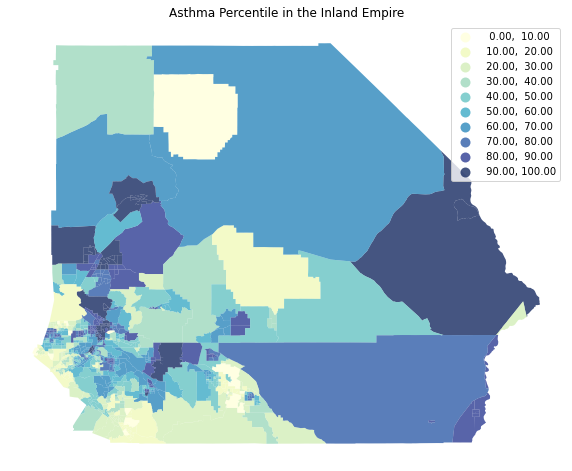

In [62]:
#plot/fig size
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

#next, give each subplot a name
ax = axs


#cvd
ces_ie.plot(column='asthmaP', 
            cmap='YlGnBu',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax,
            legend=True, scheme='user_defined', classification_kwds={'bins':
                                                                     [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
           )

#title and axis
ax.axis("off")
ax.set_title("Asthma Percentile in the Inland Empire")

According to the CES 3.0 documentation, the asthma datais the age-adjusted rate of emergency department (ED) visits for asthma per 10,000 (averaged over 2011-2013). As shown by this map, there is a variation in the ED visits for asthma throughout the Inland Empire. There are many census tracts in which the asthma percentile is over 80.

## Diesel PM Map

Text(0.5, 1.0, 'Diesel PM Percentile in the Inland Empire')

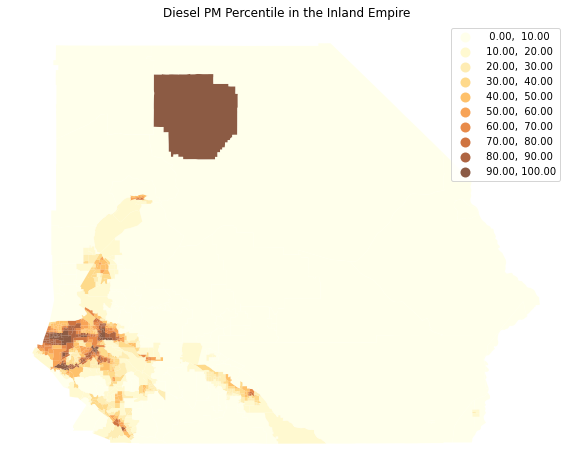

In [61]:
#plot/fig size
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

#next, give each subplot a name
ax = axs


#cvd
ces_ie.plot(column='dieselP', 
            cmap='YlOrBr',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax,
            legend=True, scheme='user_defined', classification_kwds={'bins':
                                                                     [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
           )

#title and axis
ax.axis("off")
ax.set_title("Diesel PM Percentile in the Inland Empire")

At first glance, it may look as if the diesel PM isn't much of a problem in the Inland Empire. However, it's important to note that the census tracts in this area are large. As we can see by the map, there are a good amount of census tracts that have asthma rates in the 80th percentile.

## PM 2.5 Map

Text(0.5, 1.0, 'PM 2.5 Percentile in the Inland Empire')

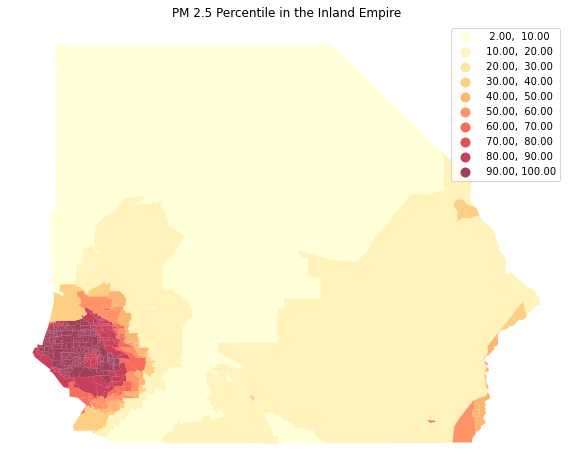

In [60]:
#plot/fig size
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

#next, give each subplot a name
ax = axs


#cvd
ces_ie.plot(column='pmP', 
            cmap='YlOrRd',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax,
            legend=True, scheme='user_defined', classification_kwds={'bins':
                                                                     [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
           )

#title and axis
ax.axis("off")
ax.set_title("PM 2.5 Percentile in the Inland Empire")

Similarly to the previous map, the high PM 2.5 percentiles are very concentrated in specific areas. I can only assume that these are the areas with higher populations and more urbanized. 

# Global Spatial Autocorrelation

Next, I'll be investigating the correlation between the census tracts for the indicators asthma, diesel PM, and PM 2.5. It's great to just map the data, but the limitation is that we're not able to provide conclusions that are statistically significant. Through the spatial autocorrelation, my hope is to provide statistically significant maps that tell a more in depth story to the data.

In [35]:
# project to web mercator
ces_ie = ces_ie.to_crs('epsg:3857')

### Spatial Weights

In [37]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(ces_ie, k=8) #KNN model is 'nearest neighbor' weight

# Row-standardization
wq.transform = 'r'

### Spatial Lag

#### Asthma

Since the asthma data is already normalized--per 10,000--there is no need for me to calculate that. Therefore, I can simply just create the spatial lag

In [42]:
# create a new column for the spatial lag
ces_ie['asthma_lag'] = lps.weights.lag_spatial(wq, ces_ie['asthma'])

In [43]:
ces_ie.sample(10)[['asthma', 'asthma_lag']]

asthma  asthma_lag
4084   26.18    31.92000
3925   29.79    29.16875
3811   62.19    57.96250
4065   60.13    55.88500
4209   51.91    60.17750
3818   84.92    84.83250
4282   19.54    26.70250
4292   20.96    24.80875
3997   36.48    32.04000
4094   69.31    54.05500

#### Diesel PM

In [44]:
# create a new column for the spatial lag
ces_ie['diesel_lag'] = lps.weights.lag_spatial(wq, ces_ie['diesel'])

In [45]:
ces_ie.sample(10)[['diesel', 'diesel_lag']]

diesel  diesel_lag
4196   39.82    35.47875
3854   12.72    12.36875
4214    7.50    14.31750
4143    3.35     3.48875
4227   14.31    28.45625
3949   12.52    11.93500
3693   18.87    27.72875
4258    8.34     9.76625
3690   42.38    28.90375
3849   33.37    28.45125

#### PM 2.5

In [46]:
# create a new column for the spatial lag
ces_ie['pm_lag'] = lps.weights.lag_spatial(wq, ces_ie['pm'])

In [47]:
ces_ie.sample(10)[['pm', 'pm_lag']]

pm    pm_lag
4232   5.76   5.65500
3864   7.02   6.94375
3651   9.54   9.53875
4106   7.02   7.17750
4048   7.02   7.02000
3563  12.89  12.89000
3950   7.02   7.33500
4167  12.89  12.89000
3796  12.89  12.89000
4209  12.89  12.89000

## Spatial Lag Maps

### Asthma

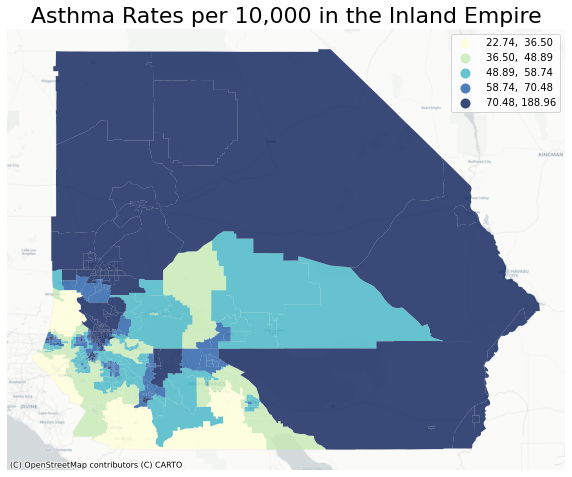

In [64]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(10, 10))

# spatial lag choropleth
ces_ie.plot(ax=ax,
         figsize=(15,15),
         column='asthma_lag',
         legend=True,
         alpha=0.8,
         cmap='YlGnBu',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Asthma Rates per 10,000 in the Inland Empire',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The map above shows the census tracts asthma rates per 10,000 in comparison to the neighboring eight census tracts. In the previous map, I used the CES 3.0 percentile data, which showed the asthma rates in the Inland Empire in comparison to the state. However, in this spatial lag map, we're able to see how the asthma rates compares to other census tracts in the Inland Empire.

### Diesel

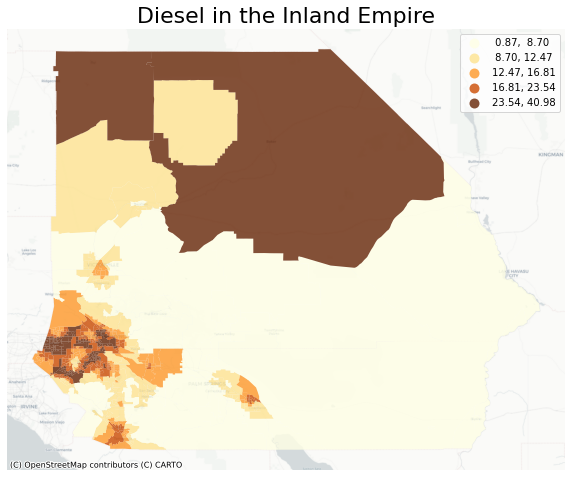

In [65]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(10, 10))

# spatial lag choropleth
ces_ie.plot(ax=ax,
         figsize=(15,15),
         column='diesel_lag',
         legend=True,
         alpha=0.8,
         cmap='YlOrBr',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Diesel in the Inland Empire',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Similarly, this map shows how diesel PM compares within each census tract in the Inland empire. Similar to the CES 3.0 percentile map, this map shows that there are concentrated areas of census tracts where the diesel PM levels are high.

### PM 2.5

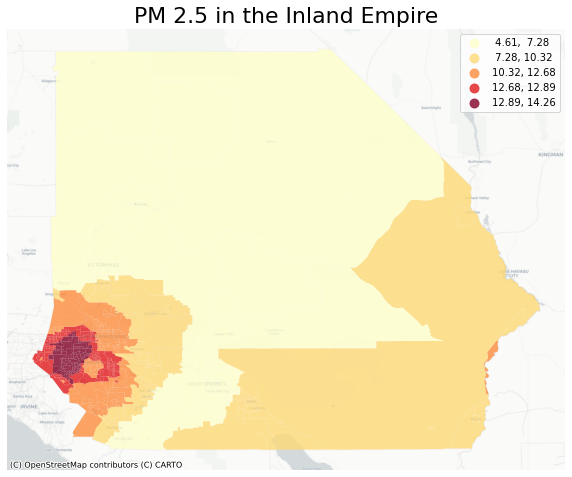

In [66]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(10, 10))

# spatial lag choropleth
ces_ie.plot(ax=ax,
         figsize=(15,15),
         column='pm_lag',
         legend=True,
         alpha=0.8,
         cmap='YlOrRd',
         scheme='quantiles')

ax.axis('off')
ax.set_title('PM 2.5 in the Inland Empire',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This map shows that there are concentrated areas of census tracts that have high PM 2.5 levels compared to their neighborhing eight census tracts.

## Moran's Plot

Now that I've calculated the spatial lag of the variables of interest, I'm going to calculate Moran's I statistic to see the spatial correlation.

### Asthma

In [67]:
y1 = ces_ie.asthma
moran = Moran(y1, wq)
moran.I

0.6553605989775674

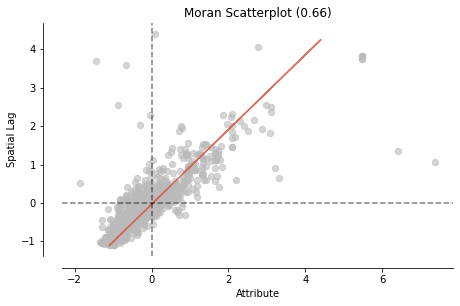

In [75]:
fig1, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [71]:
moran.p_sim

0.001

The calculations above show us that there is a strong positive spatial autocorrelation between asthma and asthma_lag (0.66). Additionally, this positive autocorrelation is significant at the p < 0.001 level.

### Diesel

In [80]:
y2 = ces_ie.diesel
moran = Moran(y2, wq)
moran.I

0.43261078183061097

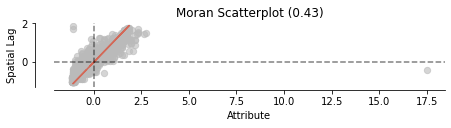

In [81]:
fig2, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [82]:
moran.p_sim

0.001

These calculations show us that there is a positive spatial autocorrelation between diesel PM and diesel PM lag (0.43). The data is statistically significant at the p < 0.001 level.

### PM 2.5

In [83]:
y3 = ces_ie.pm
moran = Moran(y3, wq)
moran.I

0.9764272168040443

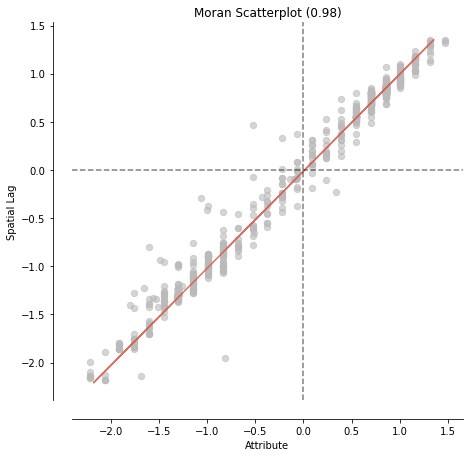

In [84]:
fig3, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [85]:
moran.p_sim

0.001

These calculations show us that there is a very strong positive spatial autocorrelation between diesel PM and diesel PM lag (0.98). The data is statistically significant at the p < 0.001 level.

# Local Spatial Autocorrelation: PM 2.5

Due to the robustness of the previous data analysis, I'll only be conducting a local spatial autocorrelation for PM 2.5 for this assignment.

## Moran Local Scatterplot

In [87]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y3, wq)

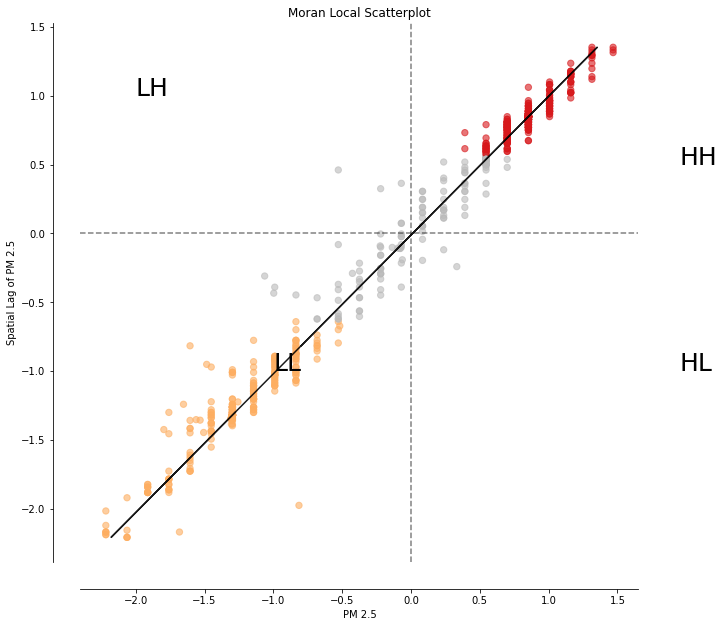

In [90]:
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("PM 2.5")
ax.set_ylabel('Spatial Lag of PM 2.5')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

This plot shows is interesting because there are only high-high (HH) and low-low (LL) for PM 2.5 at p < 0.05 level, there aren't any HL or LH. For HH, this means that there is high PM 2.5 level geographies near other high PM 2.5 level neighbors. With regards to LL, this means that there are low PM 2.5 level geograhies near other low PM 2.5 level neighbors.

## Spatial Autocorrelation Map

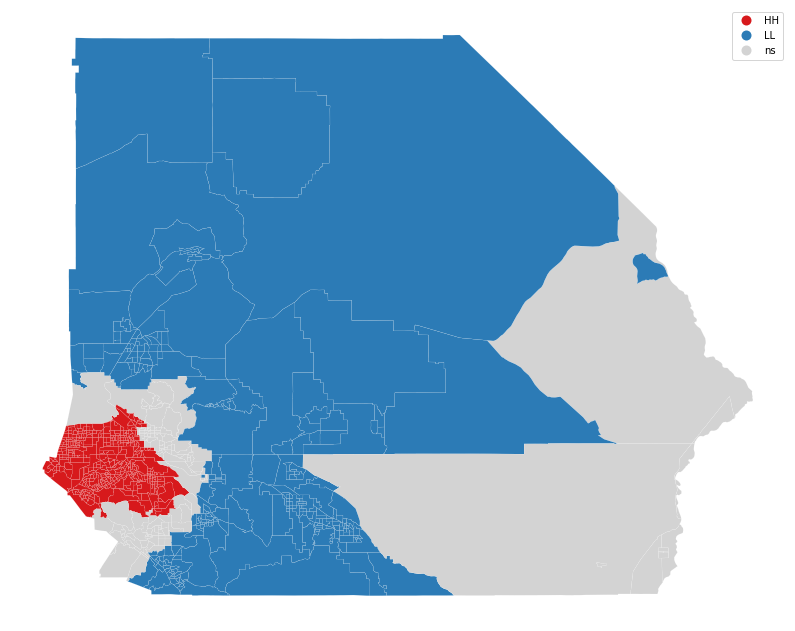

In [91]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, ces_ie, p=0.05, ax=ax)
plt.show()